In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [5]:
customers = pd.read_csv('/content/drive/MyDrive/Customers.csv')
products = pd.read_csv('/content/drive/MyDrive/Products.csv')
transactions = pd.read_csv('/content/drive/MyDrive/Transactions.csv')

In [6]:
# Merging transactions data with products
merged_data = pd.merge(transactions, products, on='ProductID', how='left')
merged_data.sample(5)

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price_x,ProductName,Category,Price_y
515,T00064,C0037,P009,2024-09-15 03:50:57,1,325.01,325.01,BookWorld Wall Art,Home Decor,325.01
190,T00032,C0109,P038,2024-11-07 01:47:33,4,588.88,147.22,TechPro Vase,Home Decor,147.22
363,T00511,C0081,P030,2024-05-26 05:56:36,3,833.58,277.86,ActiveWear Cookbook,Books,277.86
179,T00993,C0027,P040,2024-03-08 09:48:14,2,306.38,153.19,SoundWave Mystery Book,Books,153.19
598,T00585,C0056,P065,2024-01-31 08:26:51,2,855.22,427.61,BookWorld Sweater,Clothing,427.61


In [9]:
# Aggregating transaction data by Customer
customer_transactions = merged_data.groupby('CustomerID').agg(
    total_spend=('TotalValue', 'sum'),
    transaction_count=('TransactionID', 'count'),
    avg_purchase_value=('TotalValue', 'mean'),
    avg_quantity=('Quantity', 'mean'),
    most_frequent_category=('Category', lambda x: x.mode()[0])
).reset_index()
customer_transactions.sample(5)

,CustomerID,total_spend,transaction_count,avg_purchase_value,avg_quantity,most_frequent_category
47,C0048,3850.94,5,770.188000,2.400000,Electronics
84,C0085,2598.33,3,866.110000,2.333333,Books
174,C0175,6210.53,10,621.053000,2.600000,Books
56,C0057,4536.40,6,756.066667,2.666667,Books
28,C0029,1785.87,4,446.467500,2.500000,Clothing


In [10]:
merged_customer_data = pd.merge(customers, customer_transactions, on='CustomerID', how='left')
merged_customer_data.sample(5)

,CustomerID,CustomerName,Region,SignupDate,total_spend,transaction_count,avg_purchase_value,avg_quantity,most_frequent_category
13,C0014,Deborah Wilcox,Europe,2024-06-22,318.66,1.0,318.6600,2.000000,Home Decor
132,C0133,Gwendolyn Carter,South America,2023-03-11,2884.33,4.0,721.0825,2.750000,Clothing
7,C0008,David Li,North America,2024-01-13,4271.61,10.0,427.1610,2.000000,Home Decor
40,C0041,Lindsey Deleon,Europe,2023-12-27,6149.78,7.0,878.5400,3.285714,Books
136,C0137,Robert Gardner,South America,2024-04-09,3332.55,5.0,666.5100,2.200000,Books


In [11]:
merged_customer_data.isna().sum()

,0
CustomerID,0
CustomerName,0
Region,0
SignupDate,0
total_spend,1
transaction_count,1
avg_purchase_value,1
avg_quantity,1
most_frequent_category,1


In [12]:
merged_customer_data.fillna(0, inplace=True)
merged_customer_data.isna().sum()

,0
CustomerID,0
CustomerName,0
Region,0
SignupDate,0
total_spend,0
transaction_count,0
avg_purchase_value,0
avg_quantity,0
most_frequent_category,0


In [13]:
# Selecting relevant features
features = ['total_spend', 'transaction_count', 'avg_purchase_value', 'avg_quantity']

In [14]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(merged_customer_data[features])
scaled_data

array([[-0.05188436,  0.        , -0.05478053, -0.20138205],
       [-0.86271433, -0.45129368, -0.9039848 , -0.0309241 ],
       [-0.393842  , -0.45129368, -0.01157526,  1.67365539],
       [ 1.03537505,  1.35388105, -0.06116966,  0.60829321],
       [-0.76949861, -0.90258736, -0.02508596, -0.31502068],
       [ 0.42264614, -0.45129368,  1.54245503,  0.82136565],
       [-0.47295849, -0.90258736,  0.72745786,  0.25317248],
       [ 0.44658328,  2.25646841, -1.06339862, -0.88321384],
       [-1.38789656, -0.90258736, -1.59442354, -2.58779334],
       [-0.94162972, -0.45129368, -1.05418528,  0.82136565],
       [ 0.15220099,  0.        ,  0.25596967,  0.13953385],
       [ 0.96818364,  0.90258736,  0.2614437 ,  0.33434294],
       [ 1.38632271,  0.90258736,  0.71621421,  0.09083158],
       [-1.70197101, -1.80517473, -1.51238002, -0.88321384],
       [-1.24604561, -1.35388105, -0.43615877, -0.88321384],
       [ 0.23069786,  0.        ,  0.37549279, -0.88321384],
       [ 0.70867979,  1.

In [17]:
db_scores = []
sil_scores = []
inertia = []
silhouette_scores = []
for k in range(2, 11):
    # KMeans
    kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++', n_init=200, max_iter=500)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)
    db_scores.append(davies_bouldin_score(scaled_data, kmeans.labels_))
    silhouette_scores.append(silhouette_score(scaled_data, kmeans.labels_))

    # Gaussian Mixture Model
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm_labels = gmm.fit_predict(scaled_data)
    db_scores.append(davies_bouldin_score(scaled_data, gmm_labels))
    silhouette_scores.append(silhouette_score(scaled_data, gmm_labels))

    # DBSCAN (Can help capture non-linear patterns and handle noise)
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    dbscan_labels = dbscan.fit_predict(scaled_data)
    if len(set(dbscan_labels)) > 1:
        db_scores.append(davies_bouldin_score(scaled_data, dbscan_labels))
        silhouette_scores.append(silhouette_score(scaled_data, dbscan_labels))


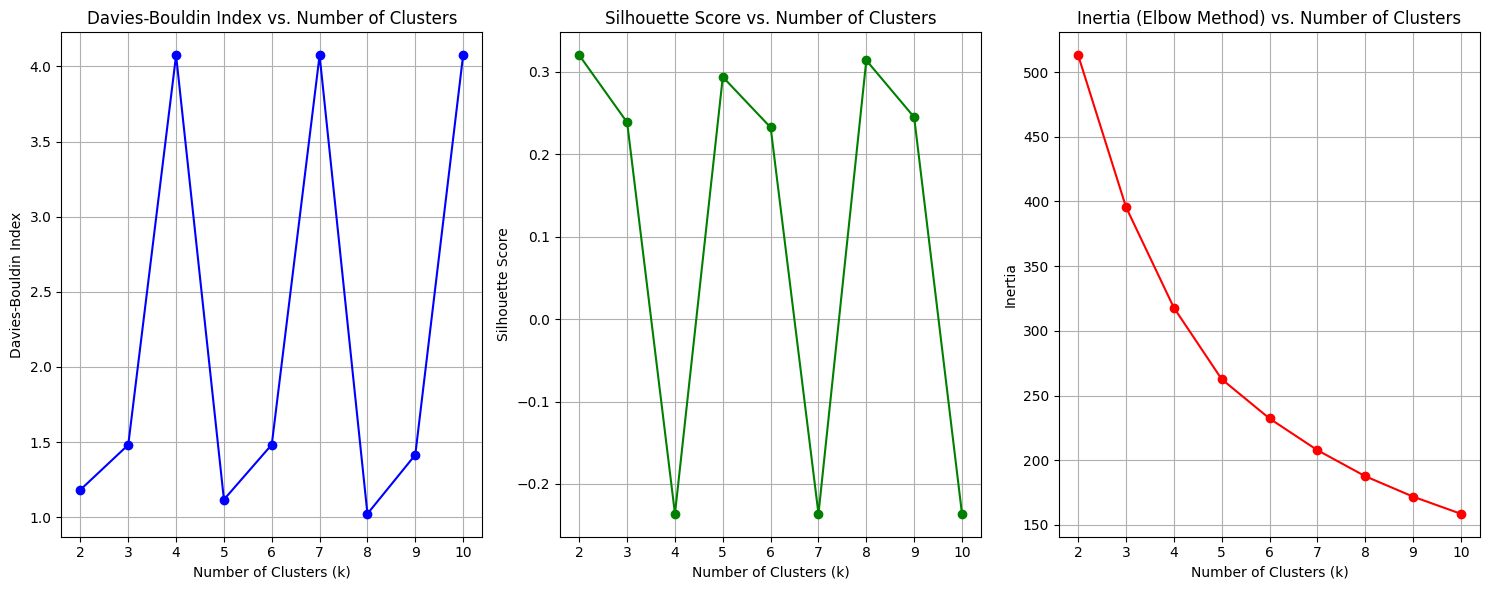

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))
ax1.plot(range(2, 11), db_scores[:9], marker='o', linestyle='-', color='b')
ax1.set_title('Davies-Bouldin Index vs. Number of Clusters')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Davies-Bouldin Index')
ax1.grid(True)

ax2.plot(range(2, 11), silhouette_scores[:9], marker='o', linestyle='-', color='g')
ax2.set_title('Silhouette Score vs. Number of Clusters')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.grid(True)

ax3.plot(range(2, 11), inertia, marker='o', linestyle='-', color='r')
ax3.set_title('Inertia (Elbow Method) vs. Number of Clusters')
ax3.set_xlabel('Number of Clusters (k)')
ax3.set_ylabel('Inertia')
ax3.grid(True)

plt.tight_layout()
plt.show()

In [19]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, init='k-means++', n_init=200, max_iter=500)
merged_customer_data['Cluster'] = kmeans.fit_predict(scaled_data)
merged_customer_data.sample(5)

,CustomerID,CustomerName,Region,SignupDate,total_spend,transaction_count,avg_purchase_value,avg_quantity,most_frequent_category,Cluster
103,C0104,Laura Bennett,South America,2022-02-10,6579.10,8.0,822.387500,2.625000,Home Decor,0
6,C0007,Paul Graves,Asia,2022-06-18,2579.82,3.0,859.940000,2.666667,Electronics,2
188,C0189,Sherri Dixon,North America,2024-01-22,2643.21,5.0,528.642000,2.200000,Home Decor,1
132,C0133,Gwendolyn Carter,South America,2023-03-11,2884.33,4.0,721.082500,2.750000,Clothing,1
158,C0159,Austin Miller,Asia,2022-08-06,2072.41,3.0,690.803333,2.666667,Home Decor,1


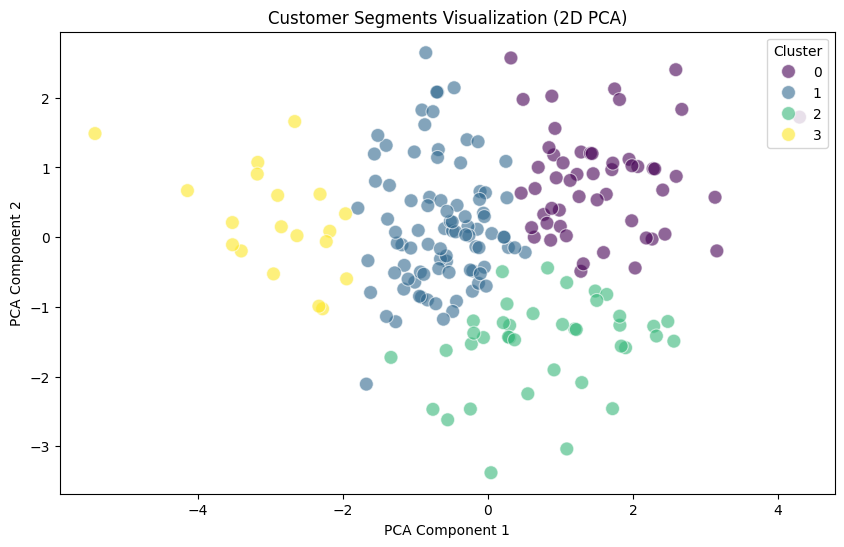

In [20]:
# Plotting the clusters in 2D using PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_data)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=merged_customer_data['Cluster'], palette='viridis', s=100, alpha=0.6)
plt.title('Customer Segments Visualization (2D PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster', loc='upper right')
plt.show()


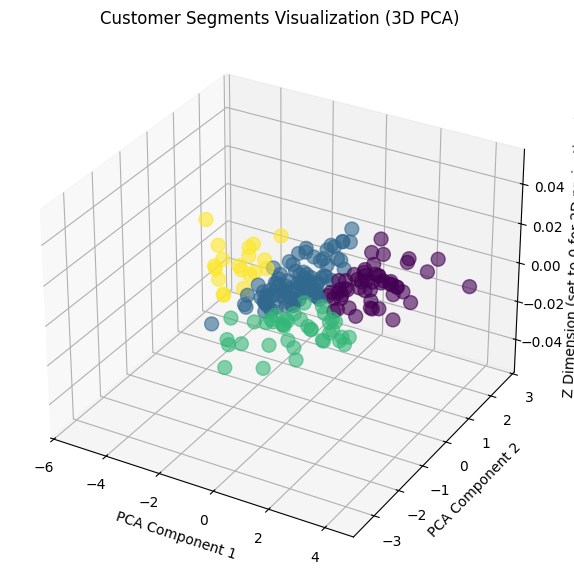

In [27]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_components[:, 0], pca_components[:, 1], np.zeros_like(pca_components[:, 0]), c=merged_customer_data['Cluster'], cmap='viridis', s=100, alpha=0.6)
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('Z Dimension (set to 0 for 2D projections)')
plt.title('Customer Segments Visualization (3D PCA)')
plt.show()

In [23]:
# Davies-Bouldin Index
db_index = davies_bouldin_score(scaled_data, merged_customer_data['Cluster'])
print(f'Davies-Bouldin Index for {optimal_k} clusters: {db_index}')

# Silhouette Score
sil_score = silhouette_score(scaled_data, merged_customer_data['Cluster'])
print(f'Silhouette Score for {optimal_k} clusters: {sil_score}')

# Cluster sizes distribution
print("Cluster Sizes:")
print(merged_customer_data['Cluster'].value_counts())

Davies-Bouldin Index for 4 clusters: 1.022596740926531
Silhouette Score for 4 clusters: 0.3141437381065478
Cluster Sizes:
Cluster
1    89
0    53
2    39
3    19
Name: count, dtype: int64


In [24]:
merged_customer_data.to_csv('Customer_Segmentation.csv', index=False)